In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams['figure.figsize'] = [15, 10]

### Proste progowanie

Sprawa jest prosta. Jeśli wartość piksela jest większa niż wartość progowa, to przypisywana jest jedna wartość (może być biała), w przeciwnym razie przypisywana jest inna wartość (może być czarna). 

W tym celu używa się funkcji __cv2.threshold__. 
- Pierwszym argumentem jest obraz źródłowy, który powinien być obrazem w __skali szarości__. 
- Drugim argumentem jest wartość progowa, która służy do klasyfikacji wartości pikseli. 
- Trzeci argument to maxVal, który reprezentuje wartość, która ma być podana, jeśli wartość piksela jest większa (czasami mniejsza) od wartości progowej. 

OpenCV dostarcza różnych stylów progowania i decyduje o tym czwarty parametr funkcji. Różne typy są:
- cv2.THRESH_BINARY:   $dst(x,y) = \texttt{maxval} ~~~ if ~~\texttt{src}(x,y) ~~> \texttt{thresh} else ~~{0}$
- cv2.THRESH_BINARY_INV: Odwrotność binarnej
- cv2.THRESH_TRUNC: $dst(x,y) = \texttt{thresh} ~~~ if ~~\texttt{src}(x,y) ~~> \texttt{thresh} else  ~~\texttt{src}(x,y)$
- cv2.THRESH_TOZERO: $dst(x,y) = \texttt{src}(x,y) ~~~ if ~~\texttt{src}(x,y) ~~> \texttt{thresh} else  ~~0$
- cv2.THRESH_TOZERO_INV: Odwrotność TOZERO



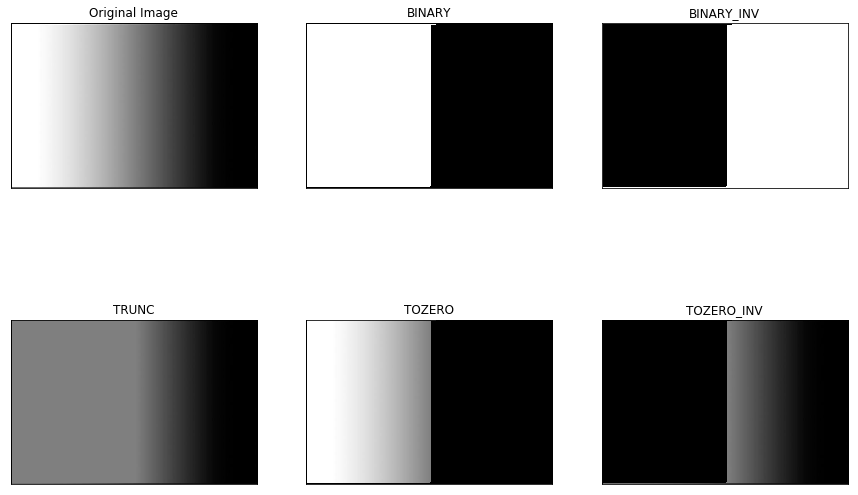

In [5]:
image = cv2.imread('images/gradient.png')

ret, thresh1 = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)
ret, thresh2 = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY_INV)
ret, thresh3 = cv2.threshold(image, 127, 255, cv2.THRESH_TRUNC)
ret, thresh4 = cv2.threshold(image, 127, 255, cv2.THRESH_TOZERO)
ret, thresh5 = cv2.threshold(image, 127, 255, cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [image, thresh1, thresh2, thresh3, thresh4, thresh5]

for i in range(6):
    plt.subplot(2,3,i+1), plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()

### Progowanie Adaptacyjne
W poprzedniej sekcji wykorzystaliśmy wartość globalną jako wartość progową. Ale może to nie być dobre we wszystkich warunkach, w których obraz ma różne warunki oświetleniowe w różnych obszarach. W takim przypadku wybieramy próg adaptacyjny. W tym algorytm oblicza próg dla małych obszarów obrazu. Otrzymujemy więc różne progi dla różnych regionów tego samego obrazu i daje nam to lepsze wyniki dla obrazów o różnym oświetleniu. Metoda adaptacyjna - decyduje o sposobie obliczania wartości progowej.

Ma trzy „specjalne” parametry wejściowe:

- __cv2.ADAPTIVE_THRESH_MEAN_C__: wartość progowa jest średnią obszaru sąsiedztwa lub __cv2.ADAPTIVE_THRESH_GAUSSIAN_C__: wartość progowa to ważona suma wartości sąsiedztwa, w których wagi są oknem gaussowskim.
- __Rozmiar bloku__ - decyduje o wielkości obszaru sąsiedztwa.
- __C__ - To tylko stała odejmowana od obliczonej średniej lub średniej ważonej.

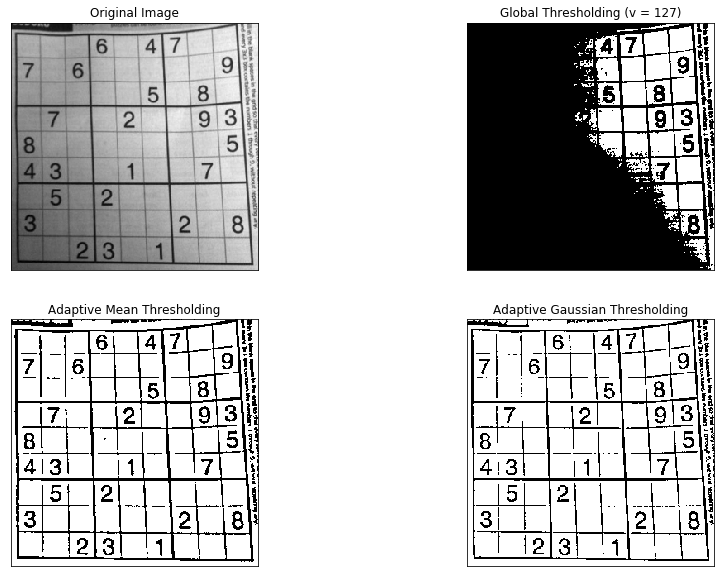

In [6]:
image = cv2.imread('images/sudoku_threshold.png', 1)
image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

pts1 = np.float32([[50, 50], [400, 50], [15, 400], [400, 400]])
pts2 = np.float32([[0,0],[300,0],[0,300],[300,300]])

transformation_matrix = cv2.getPerspectiveTransform(pts1,pts2)
image = cv2.warpPerspective(image, transformation_matrix, (300,300))

ret, th1 = cv2.threshold(image, 127, 255, cv2.THRESH_BINARY)

th2 = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY, 13, 8)
th3 = cv2.adaptiveThreshold(image, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, 13, 8)
plt.imshow(th3, cmap='gray')


titles = ['Original Image', 'Global Thresholding (v = 127)',
            'Adaptive Mean Thresholding', 'Adaptive Gaussian Thresholding']
images = [image, th1, th2, th3]

for i in range(4):
    plt.subplot(2,2,i+1),plt.imshow(images[i],'gray')
    plt.title(titles[i])
    plt.xticks([]),plt.yticks([])
plt.show()